# Как улучшить ретурн: реверс

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv('../csv/SBER_101001_201001_1d.csv',
		delimiter=',',
		parse_dates=[[0,1]],
		index_col=0,
		names=['Date','Time','Open', 'High', 'Low', 'Close', 'Volume'],
		header=0,
		encoding='utf-8'
	)

## Реверс, поменять местами бай и селл

In [3]:
def add_buy_and_sell(df):
    buy = df[['Close']].rename(columns={"Close": "Buy"})
    buy['Buy'] = df['Close'].apply(np.log)-df['Open'].apply(np.log)
    #buy['Buy_'] = (df['Close']-df['Open'])/df['Open']
    #buy['Buy_Reverse'] = df['Open'].apply(np.log)-df['Close'].apply(np.log)
    df = df.join(buy)

    sell = df[['Close']].rename(columns={"Close": "Sell"})
    sell['Sell'] = df['Open'].apply(np.log)-df['Close'].apply(np.log)
    #sell['Sell_'] = (df['Open']-df['Close'])/df['Open']
    #sell['Sell_Reverse'] = df['Close'].apply(np.log)-df['Open'].apply(np.log) 
    df = df.join(sell)

    return df

In [4]:
df = add_buy_and_sell(df)

In [5]:
def calc_n_days_reverse(values, n, reverse):
    """Проверяет есть ли n дней подряд открытия или закрытия для покупок или продаж.

    Args:
		values [list of float]: массив разницы в % между открытием и закрытие за n предыдущих дней
        n [int]: количество дней, за которые нужно проверять

	Returns:
		[float]: разница в % между открытием и закрытием за текущий день (или NaN)
    """
    if (values[:n] < 0).all():
        if reverse:
            return -1*values[-1]
        else:
            return values[-1]
    else:
        return np.nan

In [6]:
def calc_n_days_buysell_reverse(values, n, reverse):
    """Проверяет есть ли n дней подряд открытия или закрытия для покупок и продаж вместе.

    Args:
		values [list of float]: массив разницы в % между открытием и закрытие за n предыдущих дней
        n [int]: количество дней, за которые нужно проверять
        reverse [bool]: True если нужно реверсное значение, и False если обычное

	Returns:
		[float]: разница в % между открытием и закрытием за текущий день c учетом покупки или продажи (или NaN)
    """

    if (values[:n] < 0).all():
        if reverse:
            return -1*values[-1]
        else:
            return values[-1]
    elif (values[:n] > 0).all():
        if reverse:
            return values[-1]
        else:
            return -1*values[-1]
    else:
        return np.nan

In [7]:
def calc_equity(df, days, commission, reverse):
    if reverse:
        reverse_str='_Reverse'
    else:
        reverse_str = ''
    for n in tqdm(range(1,days)):
        buy_n_days = 'Buy_'+str(n)+'_Days'+reverse_str
        sell_n_days = 'Sell_'+str(n)+'_Days'+reverse_str
        buysell_n_days = 'Buysell_'+str(n)+'_Days'+reverse_str

        equity_buy = 'Equity_'+buy_n_days
        equity_sell = 'Equity_'+sell_n_days
        equity_buysell = 'Equity_'+buysell_n_days

        equity_buy_commiss = 'Equity_'+buy_n_days+'_Commiss'
        equity_sell_commiss = 'Equity_'+sell_n_days+'_Commiss'
        equity_buysell_commiss = 'Equity_'+buysell_n_days+'_Commiss'

        df[buy_n_days] = df['Buy'].rolling(n+1).apply(calc_n_days_reverse, args=(n, reverse,))
        df[sell_n_days] = df['Sell'].rolling(n+1).apply(calc_n_days_reverse, args=(n, reverse,))    
        df[buysell_n_days] = df['Buy'].rolling(n+1).apply(calc_n_days_buysell_reverse, args=(n, reverse,))

        #эквити без комиссии
        df[equity_buy] = df[buy_n_days].cumsum().apply(np.exp)
        df[equity_sell] = df[sell_n_days].cumsum().apply(np.exp)
        df[equity_buysell] = df[buysell_n_days].cumsum().apply(np.exp)

        #эквити с комиссиями
        df[equity_buy_commiss] = (df[buy_n_days]-commission/100*2).cumsum().apply(np.exp)
        df[equity_sell_commiss] = (df[sell_n_days]-commission/100*2).cumsum().apply(np.exp)
        df[equity_buysell_commiss] = (df[buysell_n_days]-commission/100*2).cumsum().apply(np.exp)    

    return df

In [8]:
def main_loop(df):
    commission = 0.06
    # days - количество дней, цикл считает до days-1
    days = 6
    df = calc_equity(df, days, commission, reverse=False)
    df = calc_equity(df, days, commission, reverse=True)
    return df

In [9]:
df = main_loop(df)

## Графики

In [10]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'

In [24]:
# Ожидание
df['Equity_Buysell_1_Days_Commiss_Rev'] = df['Equity_Buysell_1_Days_Commiss']*(-1)+2

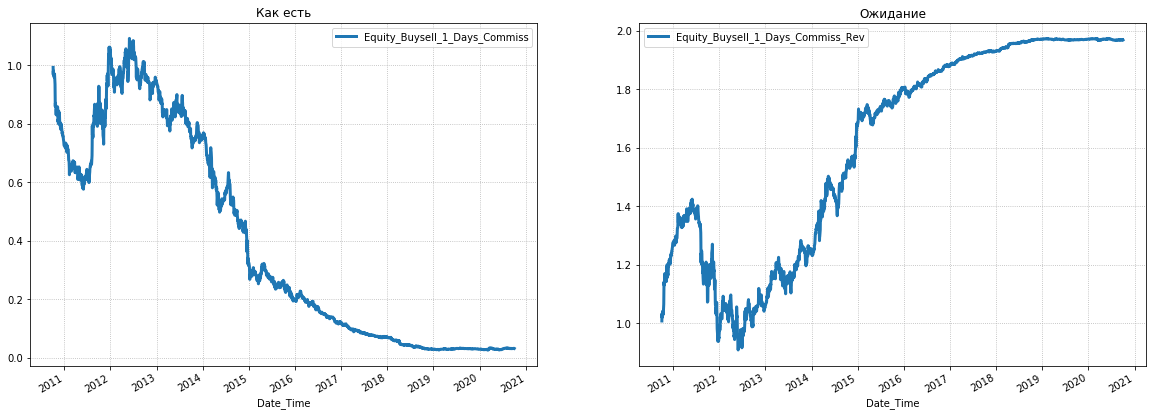

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
df[[
    'Equity_Buysell_1_Days_Commiss',
    #'Equity_Buysell_1_Days_Commiss_Rev'
]].interpolate(method='index').plot(ax=ax[0], title='Как есть')
df[[
    #'Equity_Buysell_1_Days_Commiss',
    'Equity_Buysell_1_Days_Commiss_Rev'
]].interpolate(method='index').plot(ax=ax[1], title='Ожидание')
plt.savefig('../src/waiting.png')

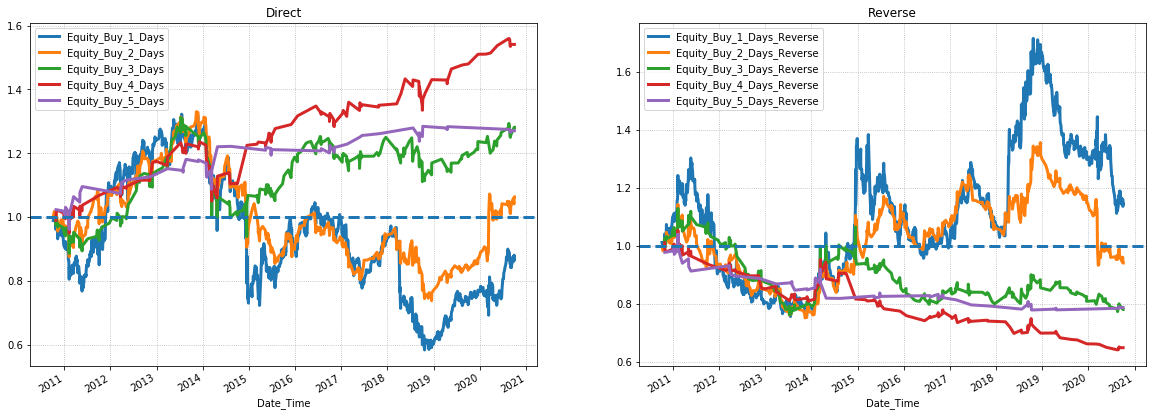

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
df[[
    'Equity_Buy_1_Days',
    'Equity_Buy_2_Days',
    'Equity_Buy_3_Days',
    'Equity_Buy_4_Days',
    'Equity_Buy_5_Days'
]].interpolate(method='index').plot(ax=ax[0], title='Direct')
df[[
    'Equity_Buy_1_Days_Reverse',
    'Equity_Buy_2_Days_Reverse',
    'Equity_Buy_3_Days_Reverse',
    'Equity_Buy_4_Days_Reverse',
    'Equity_Buy_5_Days_Reverse'
]].interpolate(method='index').plot(ax=ax[1], title='Reverse')
ax[0].axhline(y=1, linestyle='--')
ax[1].axhline(y=1, linestyle='--')
plt.savefig('../src/buy_vs_reverse.png')

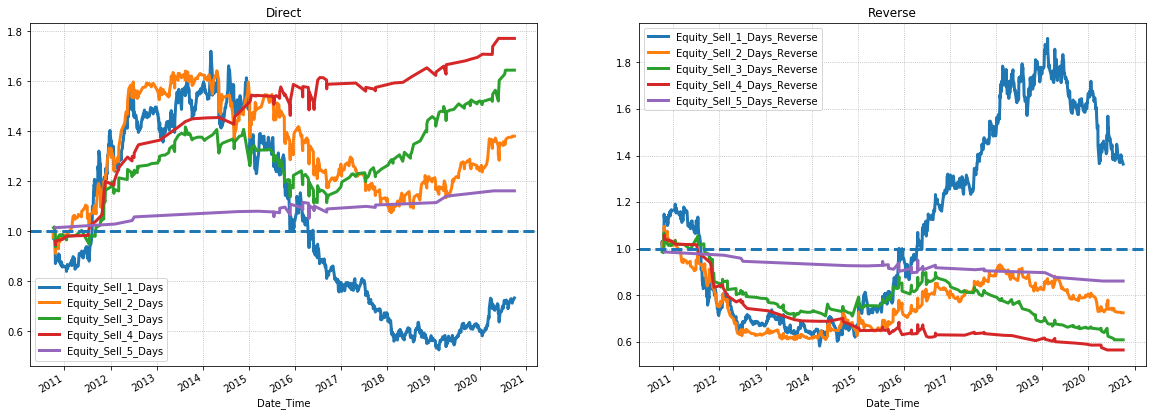

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
df[[
    'Equity_Sell_1_Days',
    'Equity_Sell_2_Days',
    'Equity_Sell_3_Days',
    'Equity_Sell_4_Days',
    'Equity_Sell_5_Days'
]].interpolate(method='index').plot(ax=ax[0], title='Direct')
df[[
    'Equity_Sell_1_Days_Reverse',
    'Equity_Sell_2_Days_Reverse',
    'Equity_Sell_3_Days_Reverse',
    'Equity_Sell_4_Days_Reverse',
    'Equity_Sell_5_Days_Reverse'
]].interpolate(method='index').plot(ax=ax[1], title='Reverse')
ax[0].axhline(y=1, linestyle='--')
ax[1].axhline(y=1, linestyle='--')
plt.savefig('../src/sell_vs_reverse.png')

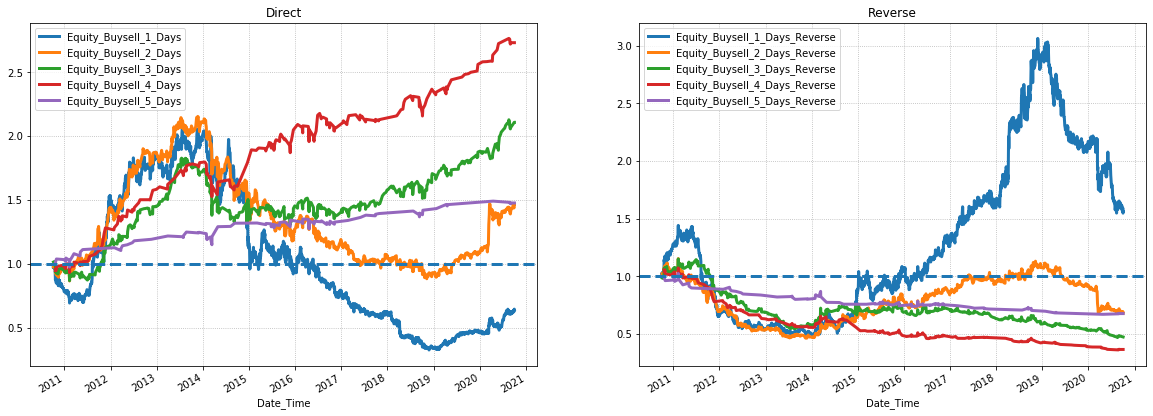

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
df[[
    'Equity_Buysell_1_Days',
    'Equity_Buysell_2_Days',
    'Equity_Buysell_3_Days',
    'Equity_Buysell_4_Days',
    'Equity_Buysell_5_Days'
]].interpolate(method='index').plot(ax=ax[0], title='Direct')
df[[
    'Equity_Buysell_1_Days_Reverse',
    'Equity_Buysell_2_Days_Reverse',
    'Equity_Buysell_3_Days_Reverse',
    'Equity_Buysell_4_Days_Reverse',
    'Equity_Buysell_5_Days_Reverse'
]].interpolate(method='index').plot(ax=ax[1], title='Reverse')
ax[0].axhline(y=1, linestyle='--')
ax[1].axhline(y=1, linestyle='--')
plt.savefig('../src/buysell_vs_reverse.png')

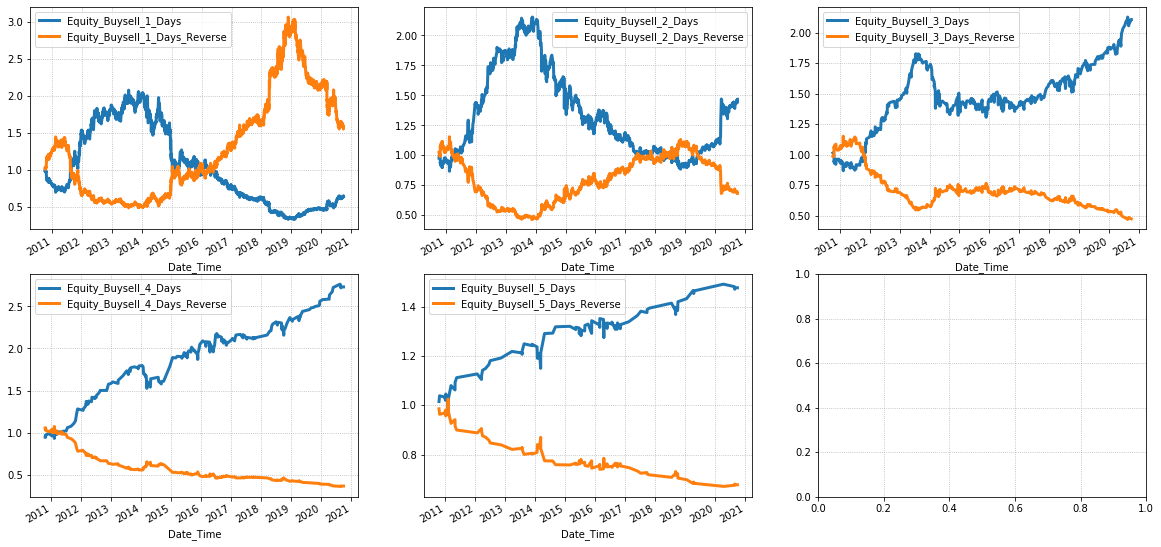

In [42]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
df[[
    'Equity_Buysell_1_Days',
    'Equity_Buysell_1_Days_Reverse'
]].interpolate(method='index').plot(ax=ax[0,0])
df[[
    'Equity_Buysell_2_Days',
    'Equity_Buysell_2_Days_Reverse'
]].interpolate(method='index').plot(ax=ax[0,1])
df[[
    'Equity_Buysell_3_Days',
    'Equity_Buysell_3_Days_Reverse'
]].interpolate(method='index').plot(ax=ax[0,2])
df[[
    'Equity_Buysell_4_Days',
    'Equity_Buysell_4_Days_Reverse'
]].interpolate(method='index').plot(ax=ax[1,0])
df[[
    'Equity_Buysell_5_Days',
    'Equity_Buysell_5_Days_Reverse'
]].interpolate(method='index').plot(ax=ax[1,1])
plt.savefig('../src/buy_vs_reverse_days.png')

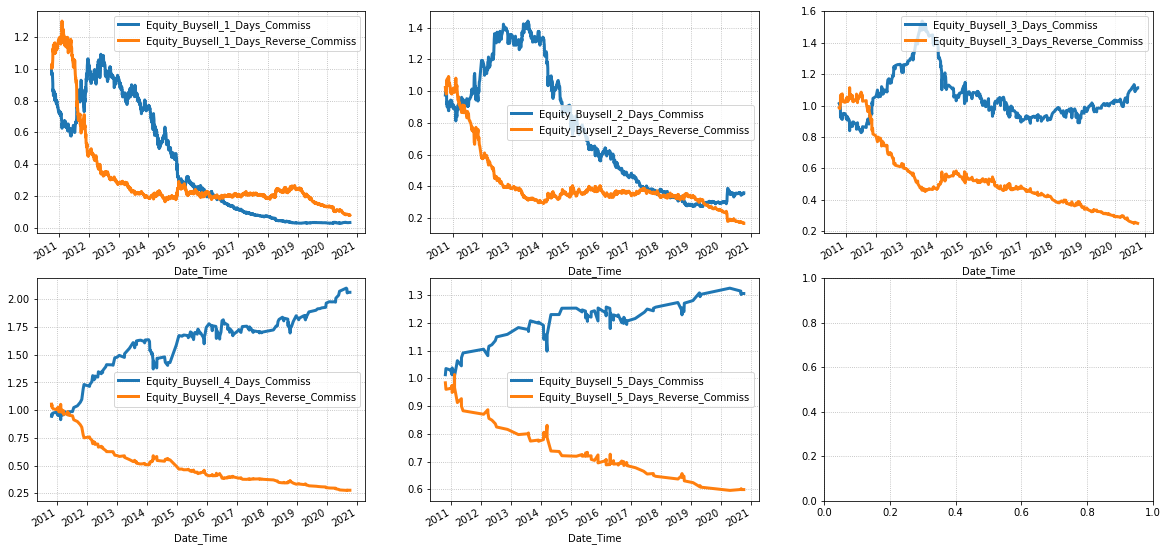

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
df[[
    'Equity_Buysell_1_Days_Commiss',
    'Equity_Buysell_1_Days_Reverse_Commiss'
]].interpolate(method='index').plot(ax=ax[0,0])
df[[
    'Equity_Buysell_2_Days_Commiss',
    'Equity_Buysell_2_Days_Reverse_Commiss'
]].interpolate(method='index').plot(ax=ax[0,1])
df[[
    'Equity_Buysell_3_Days_Commiss',
    'Equity_Buysell_3_Days_Reverse_Commiss'
]].interpolate(method='index').plot(ax=ax[0,2])
df[[
    'Equity_Buysell_4_Days_Commiss',
    'Equity_Buysell_4_Days_Reverse_Commiss'
]].interpolate(method='index').plot(ax=ax[1,0])
df[[
    'Equity_Buysell_5_Days_Commiss',
    'Equity_Buysell_5_Days_Reverse_Commiss'
]].interpolate(method='index').plot(ax=ax[1,1])
plt.savefig('../src/buy_vs_reverse_days_commiss.png')